### Mkhanyisi Gamedze
#### COSI 165B Deep Learning
#### Term Project Analysis
#### 3 May 2022



DataSet link: https://competitions.codalab.org/competitions/4081#participate-get-data or https://chalearnlap.cvc.uab.cat/dataset/17/description/

In [65]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from scipy import ndimage, misc
import imageio
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm
import time
import json

### Load Data

Build labels Dataframe

<b>Train Labels</b>

In [2]:
root=os.getcwd()
print(os.getcwd())
path="./dataset/Train_Labels"

os.chdir(path)
os.getcwd()

/Users/mkhanyisi/Desktop/Brandeis/CS /COSI 165B/Term Project


'/Users/mkhanyisi/Desktop/Brandeis/CS /COSI 165B/Term Project/dataset/Train_Labels'

In [3]:
os.getcwd()

'/Users/mkhanyisi/Desktop/Brandeis/CS /COSI 165B/Term Project/dataset/Train_Labels'

In [4]:
npath="../"
def read_text_file(file_path):
    with open(file_path, 'r') as f:
        return f.read()

rows=[]
    
# iterate through all file
for file in os.listdir():
    #print(file)
    # Check whether file is in text format or not
    if file.endswith(".txt"):
        file_path = os.getcwd()+"/"+file
        
        # call read text file function
        txt=read_text_file(file_path)
        
        txt_rows=txt.split("\n")
        txt_rows.remove('')
        
        #all_text+=str(file)+"\t"+read_text_file(file_path)
        for r in txt_rows:
            #print(r)
            a=r.split("\t")
            if a[-1]=="1":
                fn=file[:-4]
                fn=fn.replace("_train","")
                a.append(fn)
                rows.append(a)

In [5]:
len(rows)

14332

In [6]:
rows[4]

['003925.jpg', '1', 'Dia_de_los_Muertos']

<b>Validation Labels</b>

In [7]:
os.chdir(root)
val_path="./dataset/Validation_Labels"
os.chdir(val_path)
print(os.getcwd())

/Users/mkhanyisi/Desktop/Brandeis/CS /COSI 165B/Term Project/dataset/Validation_labels


In [8]:
# iterate through all file
for file in os.listdir():
    #print(file)
    # Check whether file is in text format or not
    if file.endswith(".txt"):
        file_path = os.getcwd()+"/"+file
        
        # call read text file function
        txt=read_text_file(file_path)
        
        txt_rows=txt.split("\n")
        txt_rows.remove('')
        
        #all_text+=str(file)+"\t"+read_text_file(file_path)
        for r in txt_rows:
            #print(r)
            a=r.split("\t")
            if a[-1]=="1":
                fn=file[:-4]
                fn=fn.replace("_val","")
                a.append(fn)
                rows.append(a)

In [9]:
print("Test and Validation size: ",len(rows))

Test and Validation size:  20036


In [10]:
rows[-1]

['007508.jpg', '1', 'Up_Helly_Aa']

<b> Concatenate images and labels</b>

In [71]:
labelsDF=pd.DataFrame(rows,columns=["Image Name","Label","Category"])
print(labelsDF.shape)
labelsDF.head(-5)

(20036, 3)


,Image Name,Label,Category
0,027595.jpg,1,Dia_de_los_Muertos
1,013963.jpg,1,Dia_de_los_Muertos
2,013684.jpg,1,Dia_de_los_Muertos
3,023273.jpg,1,Dia_de_los_Muertos
4,003925.jpg,1,Dia_de_los_Muertos
...,...,...,...
20026,020649.jpg,1,Up_Helly_Aa
20027,010665.jpg,1,Up_Helly_Aa
20028,025471.jpg,1,Up_Helly_Aa
20029,004733.jpg,1,Up_Helly_Aa


In [12]:
labelsDF["Label"] = labelsDF["Label"].astype(str).astype(int)

labelsDF.dtypes

Image Name    object
Label          int64
Category      object
dtype: object

<b> Encode categories</b>

In [13]:
categories=labelsDF["Category"].unique().tolist()
#categories

In [14]:
encode_vals=[]
for i in range(len(categories)):
    encode_vals.append(i)

len(categories)

100

In [15]:
encode_map = dict(zip(categories, encode_vals))
encode_map

{'Dia_de_los_Muertos': 0,
 'Ballon_Fiesta': 1,
 'Passover': 2,
 'Notting_hill_carnival': 3,
 'Non-Class': 4,
 '4_de_Julio': 5,
 'Gion_matsuri': 6,
 'Cascamorras': 7,
 'Spice_Mas_Carnival': 8,
 'Keene_Pumpkin': 9,
 'Obon': 10,
 'Diwali_Festival_of_Lights': 11,
 'Holi_Festival': 12,
 'Pingxi_Lantern_Festival': 13,
 'Festival_de_la_Marinera': 14,
 'Sapporo_Snow_Festival': 15,
 'Beltane_Fire': 16,
 'Bud_Billiken': 17,
 'Asakusa_Samba_Carnival': 18,
 'Macys_Thanksgiving': 19,
 'Frozen_Dead_Guy_Days': 20,
 'La_Tomatina': 21,
 'Sandfest': 22,
 'Heiva': 23,
 'Annual_Buffalo_Roundup': 24,
 'Junkanoo': 25,
 'Waysak_day': 26,
 'Castellers': 27,
 'Battle_of_the_Oranges': 28,
 'Mardi_Gras': 29,
 'Ati-atihan': 30,
 'Pushkar_Camel': 31,
 'Galungan': 32,
 'Renaixement_Tortosa': 33,
 'Crop_over': 34,
 'Thaipusam': 35,
 'Carnaval_de_Oruro': 36,
 'Pflasterspektakel': 37,
 'Los_Diablos_danzantes': 38,
 'Thrissur_Pooram': 39,
 'Cheongdo_Bullfighting_Festival': 40,
 'Tour_de_France': 41,
 'Oktoberfest': 42,

In [67]:
with open('event_encoding_map.json', 'w') as fp:
    json.dump(encode_map, fp,  indent=4)

In [73]:
labelsDF["Encoding"]= labelsDF.apply(lambda row: encode_map[row["Category"]], axis=1)
labelsDF.head(-5)

,Image Name,Label,Category,Encoding
0,027595.jpg,1,Dia_de_los_Muertos,0
1,013963.jpg,1,Dia_de_los_Muertos,0
2,013684.jpg,1,Dia_de_los_Muertos,0
3,023273.jpg,1,Dia_de_los_Muertos,0
4,003925.jpg,1,Dia_de_los_Muertos,0
...,...,...,...,...
20026,020649.jpg,1,Up_Helly_Aa,83
20027,010665.jpg,1,Up_Helly_Aa,83
20028,025471.jpg,1,Up_Helly_Aa,83
20029,004733.jpg,1,Up_Helly_Aa,83


In [74]:
labelsDF.to_excel("imageLabelEncodings.xlsx")  

<b>Dict map of image and category</b>

In [16]:
images_map={}

for r in rows:
    images_map.update({r[0]:{"label":r[-1]}})
    #print(r)
#print(images_map)

<b>Load and resize images</b>

In [17]:
os.chdir(root)
train_images_path="./dataset/TRAIN"
os.chdir(train_images_path)
os.getcwd()

'/Users/mkhanyisi/Desktop/Brandeis/CS /COSI 165B/Term Project/dataset/TRAIN'

In [18]:
standardsize = (256,256)
images_arr=[]
filenames=[]

In [19]:
# iterate through all file
for file in os.listdir():
    #print(file)
    # Check whether file is in text format or not
    if file.endswith(".jpg"):
        #im = Image.open(os.getcwd()+"/"+file)
        #im=im.resize(standardsize )
        im = cv2.imread(os.getcwd()+"/"+file)
        im = cv2.resize(im, dsize=(256,256))
        
        
        I = np.array(im)
        #print(I.shape)
        try:
            I=np.reshape(I,(256,256,3))
            filenames.append(file)
            images_arr.append(I)
            
            if file in images_map.keys():
                #print(images_map[file])
                images_map[file].update({"image":I})
            else:
                print(file," not in map")
        except:
            print(file)
            print("image size: ",im.size)
            print("image array shape: ",I.shape)
            plt.imshow(im)
            plt.show()

In [20]:
os.chdir(root)
train_images_path="./dataset/VAL"
os.chdir(train_images_path)
os.getcwd()

'/Users/mkhanyisi/Desktop/Brandeis/CS /COSI 165B/Term Project/dataset/VAL'

In [21]:
# iterate through all file
for file in os.listdir():
    #print(file)
    # Check whether file is in text format or not
    if file.endswith(".jpg"):
        #im = Image.open(os.getcwd()+"/"+file)
        #im=im.resize(standardsize )
        im = cv2.imread(os.getcwd()+"/"+file)
        im = cv2.resize(im, dsize=(256,256))
        
        
        I = np.array(im)
        #print(I.shape)
        try:
            I=np.reshape(I,(256,256,3))
            filenames.append(file)
            images_arr.append(I)
            
            if file in images_map.keys():
                #print(images_map[file])
                images_map[file].update({"image":I})
            else:
                print(file," not in map")
        except:
            print(file)
            print("image size: ",im.size)
            print("image array shape: ",I.shape)
            plt.imshow(im)
            plt.show()
        

In [22]:
all_images=np.array(images_arr)
print(all_images.shape)

(20036, 256, 256, 3)


In [23]:
len(images_map)

20036

In [24]:
img = np.array([[1, 2], [3, 4]])
print(img.shape)
stacked_img = np.stack((img,)*3, axis=-1)
print(stacked_img.shape)

(2, 2)
(2, 2, 3)


In [25]:
len(filenames)

20036

#### Build Numpy array with categories

Encode categories

In [26]:
# full dataset
dataX=[]
dataY=[]

for k in images_map.keys():
    dataX.append(images_map[k]["image"])
    dataY.append([encode_map[images_map[k]["label"]]]) # encode category value to dataset
    

In [27]:
fulldataX=np.array(dataX)
print(fulldataX.shape)

(20036, 256, 256, 3)


In [28]:
fulldataY=np.array(dataY)
fulldataY=fulldataY.T
print(fulldataY[0])

[ 0  0  0 ... 83 83 83]


<b>Test Transform</b>

(20036, 256, 256, 3)
(256, 256, 3)


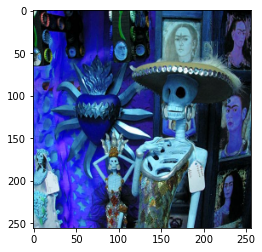

In [75]:
print(fulldataX.shape)
print(fulldataX[1].shape)
plt.imshow(fulldataX[1])

plt.show()

In [30]:
fulldataY.shape

(1, 20036)

### Save full data to numpy array

In [53]:
print(root)
print(os.getcwd())
path="./dataset/Train_Labels"

os.chdir(root)
os.getcwd()

/Users/mkhanyisi/Desktop/Brandeis/CS /COSI 165B/Term Project
/Users/mkhanyisi/Desktop/Brandeis/CS /COSI 165B/Term Project/dataset/VAL


'/Users/mkhanyisi/Desktop/Brandeis/CS /COSI 165B/Term Project'

In [54]:
np.save('fulldataX.npy', fulldataX)

In [56]:
savedDataX=np.load('fulldataX.npy')
savedDataX.shape

(20036, 256, 256, 3)

In [57]:
np.save('fulldataY.npy', fulldataY)

In [62]:
savedDataY=np.load('fulldataY.npy')
savedDataY.shape

(1, 20036)

#### To Tensor

In [63]:
tensordataX = torch.FloatTensor(fulldataX)

tensordataY = torch.FloatTensor(fulldataY.astype(int).T)


tensordataX.shape, tensordataY.shape

(torch.Size([20036, 256, 256, 3]), torch.Size([20036, 1]))

<b>Permute Images so input channel is color for convolution</b>

In [32]:
tensordataX=tensordataX.permute(0,3,1,2)
tensordataX.shape

torch.Size([20036, 3, 256, 256])

### Train-Test split (80 : 20)

In [33]:
p=int(0.8*(tensordataX.shape[0]))

trainX=tensordataX[:p]
testX=tensordataX[p:]
trainY=tensordataY[:p]
testY=tensordataY[p:]

trainX.shape, trainY.shape, testX.shape, testY.shape

(torch.Size([16028, 3, 256, 256]),
 torch.Size([16028, 1]),
 torch.Size([4008, 3, 256, 256]),
 torch.Size([4008, 1]))

### Vanilla CNN model

In [34]:
# CNN model
class Net(nn.Module):

    def __init__(self):
        super().__init__()
        
        # define convolution layers
        """
        self.conv1 = nn.Conv2d(3, 96, kernel_size=(7,7), stride=2)
        self.conv2 = nn.Conv2d(96, 512, kernel_size=(3,3), stride=1)
        """
        self.conv1 = nn.Conv2d(3, 6, kernel_size=(5,5), stride=1)
        self.conv2 = nn.Conv2d(6, 12, kernel_size=(5,5), stride=1)
        
        # figure out output conv flat length
        x = torch.randn(1,3,256,256)
        self._to_linear = None
        self.convs(x)
        
        # fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 600)
        self.fc2 = nn.Linear(600,256)
        self.fc3 = nn.Linear(256, 100)
        self.softmax = nn.Softmax(dim=1)

        
    def convs(self, x):
        # max pooling over 2x2 both Conv layers
        x=self.conv1(x)
        x=F.relu(x)
        x =F.max_pool2d(x, (2, 2))
        
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        
        
        #print(x.shape)
        # first pass, figure flat length
        if self._to_linear is None:
            print("x[0] : ",x[0].shape)
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x
    
    def forward(self, x):
        x = self.convs(x) # first two convolutional layers
        x = x.view(-1, self._to_linear) # flatten x
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x)) # Sigmoidal activation for output layer since two class problem
        #x=F.log_softmax(x, dim=1)
        
        #x=self.softmax(self.fc3(x))
        #print("x:",x.shape)
        #print("x:",x)
        return x

In [35]:
vanillaCNN=Net()

x[0] :  torch.Size([12, 61, 61])


In [36]:
#transform = torchvision.transforms.ToTensor()
img=trainX[:19]
print("image shape: ",img.shape)
print("reshaped img: ",img.view(-1,3,256,256).shape)

v=torch.randn(1,3,256,256)
print("v shape: ",v.shape)
r=vanillaCNN.forward(v)
simg=torch.squeeze(img.view(-1,3,256,256))
print("squezzed img: ",simg.shape)


im= torch.rand(10, 3, 256,256)
print("rand tensor shape: ",im.shape)
c=vanillaCNN.forward(im)

print("output: ",r)
print("rand img output: ",c.shape)

image shape:  torch.Size([19, 3, 256, 256])
reshaped img:  torch.Size([19, 3, 256, 256])
v shape:  torch.Size([1, 3, 256, 256])
squezzed img:  torch.Size([19, 3, 256, 256])
rand tensor shape:  torch.Size([10, 3, 256, 256])


/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


output:  tensor([[0.4976, 0.5227, 0.5250, 0.4974, 0.4664, 0.5120, 0.5057, 0.5113, 0.5037,
         0.5115, 0.5058, 0.5088, 0.5149, 0.4840, 0.5176, 0.5207, 0.5092, 0.5117,
         0.4912, 0.5055, 0.4998, 0.5037, 0.4630, 0.4819, 0.5275, 0.5067, 0.5109,
         0.4868, 0.4872, 0.5079, 0.5012, 0.5144, 0.5036, 0.5157, 0.5128, 0.5079,
         0.4966, 0.4872, 0.4829, 0.4736, 0.5141, 0.5113, 0.5291, 0.5077, 0.4802,
         0.4687, 0.5253, 0.5065, 0.4854, 0.5084, 0.4977, 0.4976, 0.4928, 0.5036,
         0.4957, 0.4837, 0.4973, 0.4826, 0.5103, 0.4967, 0.5101, 0.5139, 0.4769,
         0.5093, 0.4880, 0.4829, 0.4988, 0.4924, 0.4819, 0.5041, 0.4883, 0.4758,
         0.4846, 0.4815, 0.4988, 0.5058, 0.5042, 0.4870, 0.4924, 0.5124, 0.4756,
         0.4973, 0.4743, 0.5098, 0.5039, 0.4742, 0.5015, 0.5186, 0.5289, 0.4762,
         0.4749, 0.4701, 0.4902, 0.4978, 0.4965, 0.4915, 0.4858, 0.5317, 0.5164,
         0.5059]], grad_fn=<SigmoidBackward0>)
rand img output:  torch.Size([10, 100])


In [37]:
b=vanillaCNN.forward(img)
print("batch result: ",b.shape)

batch result:  torch.Size([19, 100])


In [38]:
print("CNN Model:\n",vanillaCNN)

CNN Model:
 Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44652, out_features=600, bias=True)
  (fc2): Linear(in_features=600, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=100, bias=True)
  (softmax): Softmax(dim=1)
)


#### Train model

In [39]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device "%s" for training' % dev)

Using device "cpu" for training


In [40]:
EPOCHS = 10
BATCH_SIZE = 256

In [41]:
min_loss = np.Inf #lowest loss will be the loaded model

loss_function = nn.CrossEntropyLoss().to(dev) 

optimizer = optim.Adam(vanillaCNN.parameters(),lr=0.0001)

epoch_num=[]
loss_arr=[]

enum=0
for epoch in range(EPOCHS):
    train_loss = 0
    vanillaCNN.train()
    for i in tqdm(range(0, len(trainX), BATCH_SIZE)): 
        #print(f"{i}:{i+BATCH_SIZE}")
        
        batch_X = trainX[i:i+BATCH_SIZE].to(dev)
        batch_y = trainY[i:i+BATCH_SIZE].to(dev)
        batch_y=batch_y.view(len(batch_y)).type(torch.LongTensor)
        
        vanillaCNN.zero_grad()
        #print(batch_X.shape)
        outputs = vanillaCNN(batch_X)
        
        #print("result shape: ",outputs.shape,batch_y.shape)
        
        #print(outputs.dtype)
        #print(batch_y.dtype)
        #print(outputs.shape," <=> ",batch_y.shape)
        
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()    #update weights
        
        #print(loss.item())
        #print(loss.item()," - ",len(train_x))
        train_loss += loss.item()/len(trainX)
    #print("train loss: ",train_loss)
    if epoch % 5 == 0:
        print('Epoch: {}, Train Loss: {:.4f}, Current Min Loss: {:.4f}\n'.format(   #print training loss at each step
            epoch,
            train_loss,
            min_loss
        )) 
    if train_loss < min_loss:   
        min_loss = train_loss
    print(train_loss)
    epoch_num.append(enum)
    loss_arr.append(train_loss)
    enum+=1

  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 0, Train Loss: 0.0187, Current Min Loss: inf

0.018668150482315772


  0%|          | 0/63 [00:00<?, ?it/s]

0.018514306163859247


  0%|          | 0/63 [00:00<?, ?it/s]

0.018484064653266657


  0%|          | 0/63 [00:00<?, ?it/s]

0.018474394182686444


  0%|          | 0/63 [00:00<?, ?it/s]

0.018474343265117422


  0%|          | 0/63 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 0.0185, Current Min Loss: 0.0185

0.018492764685259275


  0%|          | 0/63 [00:00<?, ?it/s]

0.018513284227572577


  0%|          | 0/63 [00:00<?, ?it/s]

0.018503967026447996


  0%|          | 0/63 [00:00<?, ?it/s]

0.018503539455719416


100%|██████████| 63/63 [06:02<00:00,  5.75s/it]

0.01850297726506689


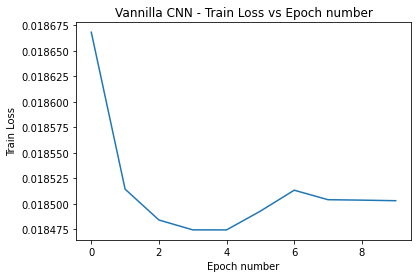

In [42]:
plt.plot(epoch_num, loss_arr)
plt.title('Vannilla CNN - Train Loss vs Epoch number')
plt.xlabel('Epoch number')
plt.ylabel('Train Loss')
plt.show()

#### Test

In [43]:
#def test(model,test_x,test_y):
def model_test(test_x,test_y, model, epoch_num=EPOCHS):
    model.train(False)
    correct = 0
    total = 0

    #print(test_y)
    with torch.no_grad():
        for i in tqdm(range(len(test_x))):
            real_class = test_y[i].to(dev)
            images=test_x[i].view(-1,3,64,64).to(dev)
            net_out = model(images) # returns a list, 

            predicted_class = torch.argmax(net_out,dim=1)
            #print(net_out," =>",predicted_class," : ",real_class)
            if predicted_class == real_class:
                correct += 1
                #print(net_out," =>",predicted_class," : ",real_class)
            total += 1
    print("Accuracy: ", round((correct/total)*100, 3)," % ")

In [44]:
vanillaCNN.train(False)
correct = 0
total = 0

#print(test_y)

with torch.no_grad():
    for i in tqdm(range(len(testX))):
        real_class = testY[i].to(dev)
        images=testX[i].view(-1,3,256,256).to(dev)
        net_out = vanillaCNN(images) # returns a list, 
        
        predicted_class = torch.argmax(net_out,dim=1)
        #print(net_out," =>",predicted_class," : ",real_class)
        #print(predicted_class.shape," : ",real_class.shape)
        if predicted_class == real_class:
            correct += 1
            #print(net_out," =>",predicted_class," : ",real_class)
        total += 1
print("Initial Model Accuracy: ", round((correct/total)*100, 3)," % ")

100%|██████████| 4008/4008 [01:01<00:00, 65.52it/s]

Initial Model Accuracy:  1.198  % 


### Resources

- https://competitions.codalab.org/competitions/4081#participate-get-data
- 


- https://blog.keras.io/running-jupyter-notebooks-on-gpu-on-aws-a-starter-guide.html

##### 